# Modelling Amazon at Delivery Level

In [1]:
%load_ext autoreload
%autoreload 2

# Individual City Regression


In [2]:
# ruff: noqa: E402
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

import polars as pl
import numpy as np
import pandas as pd

## Create the Dataset


In [3]:
from src.osm_tags import build_tag_filter
from src.config import load_config
from src.models.dataset import ServiceTimeDataset

config = load_config(ROOT / "config" / "paper.yaml")


dataset = (
    ServiceTimeDataset(
        config=config,
        cities=["Boston, USA", "Seattle, USA", "Austin, USA", "Chicago, USA"],
    )
    # .add_super_tags()
    # .add_tags()
)

## Train / Test at Delivery Level

In [4]:
# just using dataset object here as convient way to crop to city boundaries
df  = dataset.df.filter(
    pl.col('city').str.contains('Boston')
).select(['region_id', *list(map(str, range(50)))]).join(
    pl.read_parquet(config.ServiceTime[-1].file),
    on=['region_id']
).rename({
    'planned_service_time': 'service_time'
})

In [5]:
df.shape

(1289359, 72)

In [12]:
X = df.select([
    # embeddings
    *list(map(str, range(50))),
    # 'has_time_window',
    'has_time_window',
    # number of packages per delivery
    'package_num',
    # 'height',
    # 'width',
    # 'depth',
    # the time of day
    pl.col('arrival_datetime').dt.hour().alias('hour'),
    # the day of the week
    pl.col('arrival_datetime').dt.weekday().alias('day_of_week'),
    # size of the vehicle
    pl.col('executor_capacity_cm3') / (100 * 100 * 100),
    # volume of the packages
    ((pl.col('height') * pl.col('width') * pl.col('depth'))/ (100 * 100 * 100)).alias('volume'),
]).to_numpy()

Y = df.select([
    pl.col('service_time')
]).to_numpy()

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42
)


model = XGBRegressor(
    objective="reg:tweedie",
    tweedie_variance_power=1.1,
    n_estimators=1500,
    max_depth=12,
    learning_rate=0.005,
    subsample=0.9,
    colsample_bytree=0.9,
    n_jobs=-1,
    verbosity=1,
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="mae",
    verbose=True,
)

/Users/max/.pyenv/versions/3.11.6/envs/cargo-bike-analysis-11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:13112.16230	validation_1-mae:13112.40608
[1]	validation_0-mae:13039.62956	validation_1-mae:13039.87145
[2]	validation_0-mae:12967.49937	validation_1-mae:12967.73924
[3]	validation_0-mae:12895.76800	validation_1-mae:12896.00577
[4]	validation_0-mae:12824.43445	validation_1-mae:12824.66959
[5]	validation_0-mae:12753.49596	validation_1-mae:12753.72906
[6]	validation_0-mae:12682.95032	validation_1-mae:12683.18099
[7]	validation_0-mae:12612.79583	validation_1-mae:12613.02457
[8]	validation_0-mae:12543.03037	validation_1-mae:12543.25669
[9]	validation_0-mae:12473.65057	validation_1-mae:12473.87509
[10]	validation_0-mae:12404.65633	validation_1-mae:12404.87916
[11]	validation_0-mae:12336.04351	validation_1-mae:12336.26399
[12]	validation_0-mae:12267.81106	validation_1-mae:12268.02979
[13]	validation_0-mae:12199.95584	validation_1-mae:12200.17188
[14]	validation_0-mae:12132.47724	validation_1-mae:12132.69114
[15]	validation_0-mae:12065.37271	validation_1-mae:12065.58631
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=-1,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [13]:
# check the r2
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.9594996706699671

Text(0, 0.5, 'Predicted')

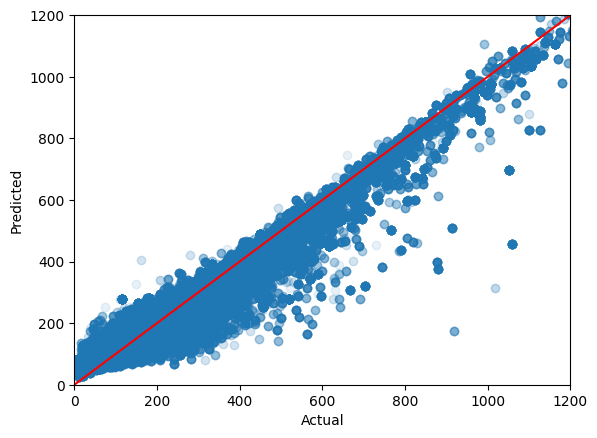

In [14]:
# scatter plot of predicted vs actual
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.1)

# make it a square
plt.xlim(0, 1200)
plt.ylim(0, 1200)

# add a diagonal line
plt.plot([0, 1200], [0, 1200], color="red")

# add labels
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [19]:
import xgboost

sorted(model.get_booster().get_fscore().items(), key=lambda x: x[1], reverse=True)

[('f55', 519089.0),
 ('f0', 454428.0),
 ('f52', 304433.0),
 ('f53', 180109.0),
 ('f1', 138447.0),
 ('f2', 71801.0),
 ('f51', 64071.0),
 ('f50', 57634.0),
 ('f54', 50486.0),
 ('f3', 49326.0),
 ('f4', 37029.0),
 ('f5', 29848.0),
 ('f7', 24780.0),
 ('f6', 24749.0),
 ('f9', 20403.0),
 ('f8', 18474.0),
 ('f13', 17712.0),
 ('f10', 16801.0),
 ('f12', 16408.0),
 ('f11', 16406.0),
 ('f24', 16259.0),
 ('f17', 16163.0),
 ('f20', 15713.0),
 ('f23', 15089.0),
 ('f15', 14847.0),
 ('f14', 14844.0),
 ('f21', 14607.0),
 ('f16', 14573.0),
 ('f18', 14367.0),
 ('f34', 13784.0),
 ('f46', 13468.0),
 ('f49', 13242.0),
 ('f32', 13030.0),
 ('f25', 12804.0),
 ('f37', 12776.0),
 ('f47', 12279.0),
 ('f36', 12140.0),
 ('f19', 12014.0),
 ('f29', 11891.0),
 ('f27', 11648.0),
 ('f39', 11563.0),
 ('f48', 11537.0),
 ('f45', 11399.0),
 ('f22', 11341.0),
 ('f35', 11258.0),
 ('f26', 11257.0),
 ('f31', 11217.0),
 ('f28', 11103.0),
 ('f33', 10922.0),
 ('f42', 10438.0),
 ('f41', 10434.0),
 ('f30', 9801.0),
 ('f44', 9396.0),


In [27]:
cols = df.select([
    # embeddings
    *list(map(str, range(50))),
    # 'has_time_window',
    'has_time_window',
    # number of packages per delivery
    'package_num',
    # 'height',
    # 'width',
    # 'depth',
    # the time of day
    pl.col('arrival_datetime').dt.hour().alias('hour'),
    # the day of the week
    pl.col('arrival_datetime').dt.weekday().alias('day_of_week'),
    # size of the vehicle
    pl.col('executor_capacity_cm3') / (100 * 100 * 100),
    # volume of the packages
    ((pl.col('height') * pl.col('width') * pl.col('depth'))/ (100 * 100 * 100)).alias('volume'),
]).columns

cols[55], cols[52], cols[53], cols[51], cols[50]

('volume', 'hour', 'day_of_week', 'package_num', 'has_time_window')